In [1]:
# !pip install py7zr

In [2]:
# https://www.kaggle.com/datasets/yapwh1208/cats-breed-dataset
# https://www.kaggle.com/datasets/trolukovich/food11-image-dataset?select=training
# https://www.kaggle.com/datasets/gpiosenka/tree-nuts-image-classification?select=train

In [3]:
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor,InterpolationMode
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import requests
import pandas as pd
from pathlib import Path
import numpy as np
import os
import zipfile
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score
from tqdm.auto import tqdm
from collections import Counter

In [4]:
# set device by checking if gpu is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [5]:
SEED = 50

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [6]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# root directory for data
root_dir = 'drive/MyDrive/Colab Notebooks/Deep Learning Fundamentals/Assignment 2/'

Mounted at /content/drive


**DATA PREPROCESSING AND VISUALIZATION**

In [7]:
with zipfile.ZipFile(root_dir + 'food-11.zip', 'r') as zip_ref:
    zip_ref.extractall('food-11/')

In [8]:
image_transform = transforms.Compose([
    transforms.Resize(size=(224,224)), # resize the image
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # apply data augmentation
    transforms.ToTensor(), # convert the image into a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
train_data = datasets.ImageFolder('food-11/training/', transform=image_transform)
val_data = datasets.ImageFolder('food-11/validation/', transform=image_transform)
test_data = datasets.ImageFolder('food-11/evaluation/', transform=image_transform)

In [10]:
class_names = train_data.classes
print(class_names)

['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']


In [11]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

9866
3430
3347


In [12]:
image,label = train_data[0]
print(image.shape)
print(label)

torch.Size([3, 224, 224])
0


Text(0.5, 1.0, 'Bread')

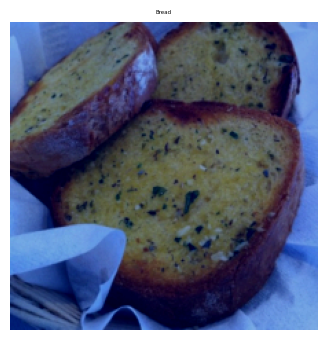

In [13]:
# rearrange the image dimensions
image_permute = image.permute(1,2,0)

# display the image
plt.figure(figsize=(6,4))
plt.imshow(image_permute)
plt.axis("off")
plt.title(train_data.classes[label], fontsize=4)

In [14]:
BATCH_SIZE = 64

# convert dataset to dataloader
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

val_dataloader = DataLoader(val_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

In [15]:
# get a batch of images and labels from the dataloader
train_images,train_labels = next(iter(train_dataloader))
print(train_images.shape)
print(train_labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


**TRAINING**

In [16]:
# function to calculate accuracy
def accuracy(labels,preds):
    correct = torch.eq(labels,preds).sum().item()
    acc = (correct/len(labels))*100
    return acc

In [17]:
def train(model, dataloader, criterion, optimizer):
    # set the model to training mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (images, labels) in enumerate(dataloader):
        # send data to target device
        images, labels = images.to(device), labels.to(device)

        # pass the data to the model and get model outputs
        logits = model(images)

        # calulate the loss
        loss = criterion(logits, labels)
        train_loss += loss.item()

        # clear the gradients
        optimizer.zero_grad()

        # calculate the gradients
        loss.backward()

        # update the model parameters
        optimizer.step()

        # calculate the accuracy
        train_acc = train_acc+accuracy(labels,torch.argmax(logits,dim=1))

    # calculate the mean loss
    train_loss = train_loss / len(dataloader)

    # calculate the mean accuracy
    train_acc = train_acc / len(dataloader)

    return train_loss,train_acc

In [18]:
def test(model, dataloader, criterion):
    # set the model to testing mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (images, labels) in enumerate(dataloader):
            # send data to target device
            images, labels = images.to(device), labels.to(device)

            # pass the data to the model and get model outputs
            logits = model(images)

            # calulate the loss
            loss = criterion(logits, labels)
            test_loss += loss.item()

            # calculate the accuracy
            test_acc = test_acc+accuracy(labels,torch.argmax(logits,dim=1))

    # calculate the mean loss
    test_loss = test_loss / len(dataloader)

    # calculate the mean accuracy
    test_acc = test_acc / len(dataloader)

    return test_loss,test_acc

In [19]:
def evaluate(model, dataloader, class_names):
    # Set the model to evaluation mode
    model.eval()

    all_preds = []
    all_labels = []
    all_top5_preds = []

    with torch.inference_mode():
        for batch, (images, labels) in enumerate(dataloader):
            # Send data to target device
            images, labels = images.to(device), labels.to(device)

            # Get predictions from the model
            logits = model(images)
            preds = torch.argmax(logits, dim=1)
            top5_preds = torch.topk(logits, k=5, dim=1).indices  # Get top 5 predictions

            # Accumulate predictions and true labels
            all_preds = all_preds + preds.cpu().tolist()
            all_labels = all_labels + labels.cpu().tolist()
            all_top5_preds = all_top5_preds + top5_preds.cpu().tolist()

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_top5_preds = np.array(all_top5_preds)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(all_labels, all_preds)

    # Calculate top-5 accuracy
    top5_correct = 0
    for i in range(len(all_labels)):
        if all_labels[i] in all_top5_preds[i]:
            top5_correct += 1
    top5_accuracy = top5_correct / len(all_labels)

    # Calculate per-class accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

    # Calculate per-class recall
    per_class_recall = recall_score(all_labels, all_preds, average=None)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print metrics
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Top-5 Accuracy: {top5_accuracy:.4f}")
    print("\nPer-Class Accuracy:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {per_class_accuracy[i]:.4f}")

    print("\nPer-Class Recall:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {per_class_recall[i]:.4f}")

In [20]:
# function to plot the loss and accuracy
def plot_curves(results):
    plt.figure(figsize=(15,7))
    epochs = range(1,len(results["train_loss"])+1)

    # plot the losses
    plt.subplot(1,2,1)
    plt.plot(epochs,results["train_loss"], label="Training Loss")
    plt.plot(epochs,results["val_loss"], label="Validation Loss")
    plt.title("LOSS")
    plt.xlabel("Epochs")
    plt.legend()

    # # plot the accuracies
    # plt.subplot(1,2,2)
    # plt.plot(epochs,results["train_acc"], label="Training Accuracy")
    # plt.plot(epochs,results["test_acc"], label="Test Accuracy")
    # plt.title("ACCURACY")
    # plt.xlabel("Epochs")
    # plt.legend()

**VGG-16**

In [21]:
# get pretrained model weights
weights = torchvision.models.VGG16_Weights.DEFAULT

model = torchvision.models.vgg16(weights=weights).to(device)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 169MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
# freeze the convolutional layers of the model
for param in model.features.parameters():
    param.requires_grad = False

In [23]:
# update the classifier of the model
# the output size of the layer should be same as the number of classes in the data
model.classifier = nn.Sequential(
    nn.Linear(25088,4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5,inplace=False),
    nn.Linear(4096,4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5,inplace=False),
    nn.Linear(4096,len(train_data.classes))
).to(device)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [24]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
epochs = 4

# results dictionary
results = {"train_loss": [],
            "val_loss": [],
}

In [26]:
for epoch in tqdm(range(epochs)):
    train_loss,train_acc = train(model,train_dataloader,criterion,optimizer)
    val_loss,val_acc = test(model,val_dataloader,criterion)

    print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}% | val_loss: {val_loss:.4f} | val_acc: {val_acc:.2f}%")

    # update the results dictionary
    results["train_loss"].append(train_loss)
    #results["train_acc"].append(train_acc)
    results["val_loss"].append(val_loss)
    #results["test_acc"].append(test_acc)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7382 | train_acc: 56.55% | val_loss: 0.9602 | val_acc: 69.17%
Epoch: 2 | train_loss: 1.0369 | train_acc: 67.80% | val_loss: 0.8588 | val_acc: 71.88%
Epoch: 3 | train_loss: 0.9672 | train_acc: 70.06% | val_loss: 0.8780 | val_acc: 72.46%
Epoch: 4 | train_loss: 0.9682 | train_acc: 71.69% | val_loss: 0.9152 | val_acc: 71.56%


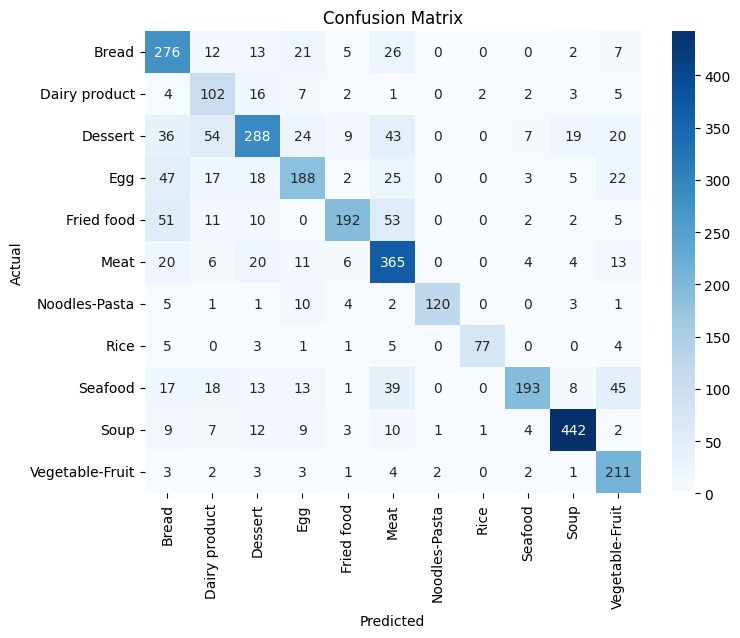

Overall Accuracy: 0.7155
Top-5 Accuracy: 0.9534

Per-Class Accuracy:
Bread: 0.7624
Dairy product: 0.7083
Dessert: 0.5760
Egg: 0.5749
Fried food: 0.5890
Meat: 0.8129
Noodles-Pasta: 0.8163
Rice: 0.8021
Seafood: 0.5562
Soup: 0.8840
Vegetable-Fruit: 0.9095

Per-Class Recall:
Bread: 0.7624
Dairy product: 0.7083
Dessert: 0.5760
Egg: 0.5749
Fried food: 0.5890
Meat: 0.8129
Noodles-Pasta: 0.8163
Rice: 0.8021
Seafood: 0.5562
Soup: 0.8840
Vegetable-Fruit: 0.9095


In [27]:
evaluate(model, val_dataloader, class_names)

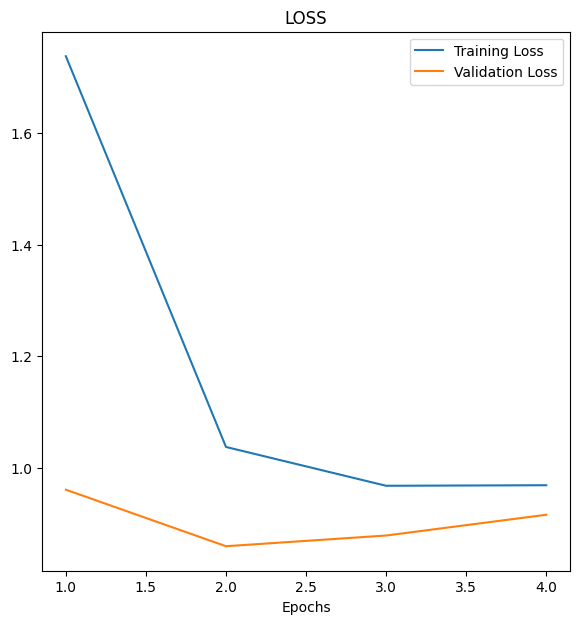

In [28]:
plot_curves(results)

**RESNET-18**

In [29]:
# get pretrained model weights
weights = torchvision.models.ResNet18_Weights.DEFAULT

model = torchvision.models.resnet18(weights=weights).to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 202MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
# freeze the convolutional layers of the model
for param in model.parameters():
    param.requires_grad = False

In [31]:
# update the classifier of the model
# the output size of the layer should be same as the number of classes in the data
model.fc = nn.Linear(512,len(train_data.classes)).to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [33]:
epochs = 4

# results dictionary
results = {"train_loss": [],
            "val_loss": [],
}

In [34]:
for epoch in tqdm(range(epochs)):
    train_loss,train_acc = train(model,train_dataloader,criterion,optimizer)
    val_loss,val_acc = test(model,val_dataloader,criterion)

    print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}% | val_loss: {val_loss:.4f} | val_acc: {val_acc:.2f}%")

    # update the results dictionary
    results["train_loss"].append(train_loss)
    #results["train_acc"].append(train_acc)
    results["val_loss"].append(val_loss)
    #results["test_acc"].append(test_acc)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5058 | train_acc: 51.69% | val_loss: 1.1367 | val_acc: 64.14%
Epoch: 2 | train_loss: 1.0147 | train_acc: 67.79% | val_loss: 0.9638 | val_acc: 69.42%
Epoch: 3 | train_loss: 0.9091 | train_acc: 70.57% | val_loss: 0.9042 | val_acc: 70.66%
Epoch: 4 | train_loss: 0.8645 | train_acc: 71.82% | val_loss: 0.8627 | val_acc: 71.94%


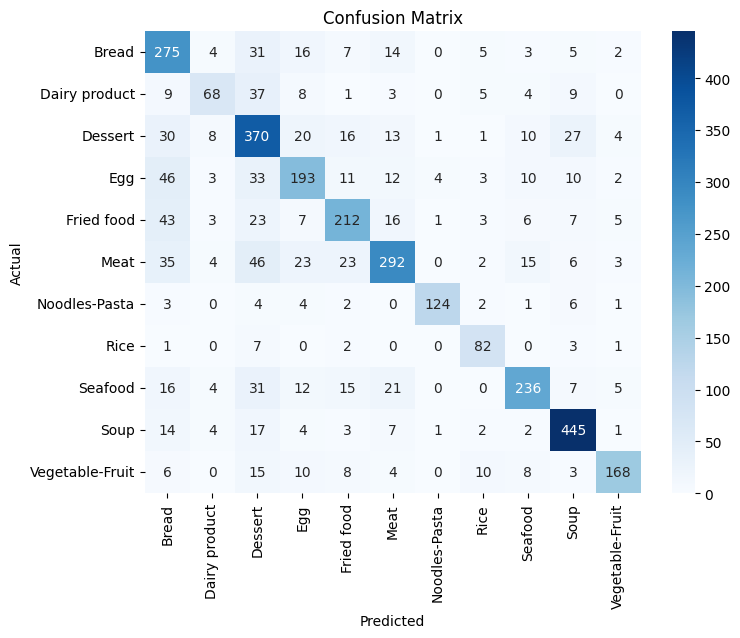

Overall Accuracy: 0.7187
Top-5 Accuracy: 0.9703

Per-Class Accuracy:
Bread: 0.7597
Dairy product: 0.4722
Dessert: 0.7400
Egg: 0.5902
Fried food: 0.6503
Meat: 0.6503
Noodles-Pasta: 0.8435
Rice: 0.8542
Seafood: 0.6801
Soup: 0.8900
Vegetable-Fruit: 0.7241

Per-Class Recall:
Bread: 0.7597
Dairy product: 0.4722
Dessert: 0.7400
Egg: 0.5902
Fried food: 0.6503
Meat: 0.6503
Noodles-Pasta: 0.8435
Rice: 0.8542
Seafood: 0.6801
Soup: 0.8900
Vegetable-Fruit: 0.7241


In [35]:
evaluate(model, val_dataloader, class_names)

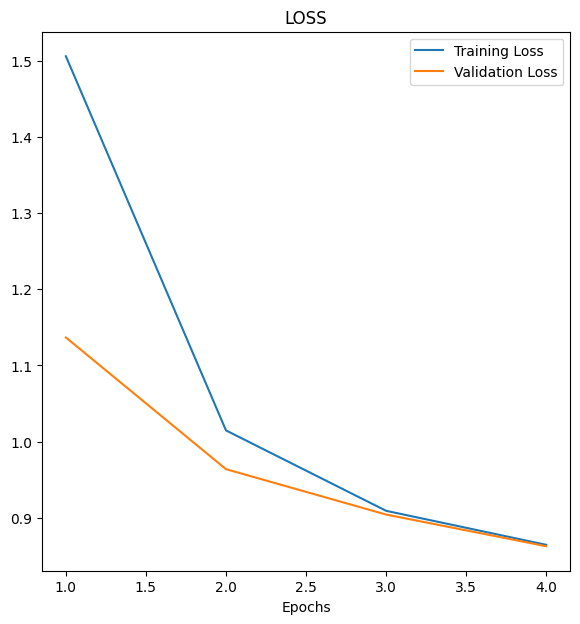

In [36]:
plot_curves(results)

**VISION TRANSFORMER**

In [37]:
# get pretrained model weights
weights = torchvision.models.ViT_B_16_Weights.DEFAULT

model = torchvision.models.vit_b_16(weights=weights).to(device)
print(model)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 119MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [38]:
# freeze the convolutional layers of the model
for param in model.encoder.parameters():
    param.requires_grad = False

In [39]:
# update the classifier of the model
# the output size of the layer should be same as the number of classes in the data
model.heads = nn.Sequential(
    nn.Linear(768,len(train_data.classes))
).to(device)

print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [40]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.0004)

In [41]:
epochs = 2

# results dictionary
results = {"train_loss": [],
            "val_loss": [],
}

In [42]:
for epoch in tqdm(range(epochs)):
    train_loss,train_acc = train(model,train_dataloader,criterion,optimizer)
    val_loss,val_acc = test(model,val_dataloader,criterion)

    print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}% | val_loss: {val_loss:.4f} | val_acc: {val_acc:.2f}%")

    # update the results dictionary
    results["train_loss"].append(train_loss)
    #results["train_acc"].append(train_acc)
    results["val_loss"].append(val_loss)
    #results["test_acc"].append(test_acc)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9041 | train_acc: 35.07% | val_loss: 1.5805 | val_acc: 48.05%
Epoch: 2 | train_loss: 1.2884 | train_acc: 58.07% | val_loss: 1.1267 | val_acc: 63.81%


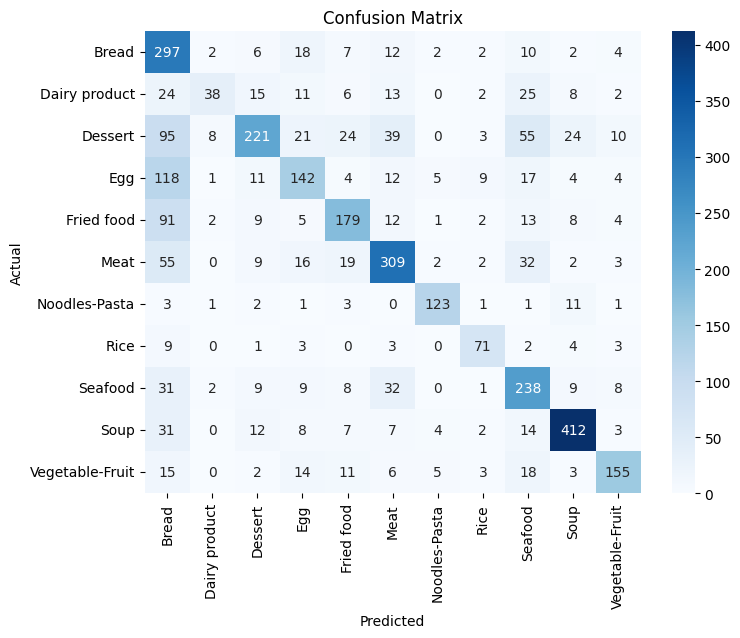

Overall Accuracy: 0.6370
Top-5 Accuracy: 0.9440

Per-Class Accuracy:
Bread: 0.8204
Dairy product: 0.2639
Dessert: 0.4420
Egg: 0.4343
Fried food: 0.5491
Meat: 0.6882
Noodles-Pasta: 0.8367
Rice: 0.7396
Seafood: 0.6859
Soup: 0.8240
Vegetable-Fruit: 0.6681

Per-Class Recall:
Bread: 0.8204
Dairy product: 0.2639
Dessert: 0.4420
Egg: 0.4343
Fried food: 0.5491
Meat: 0.6882
Noodles-Pasta: 0.8367
Rice: 0.7396
Seafood: 0.6859
Soup: 0.8240
Vegetable-Fruit: 0.6681


In [43]:
evaluate(model, val_dataloader, class_names)

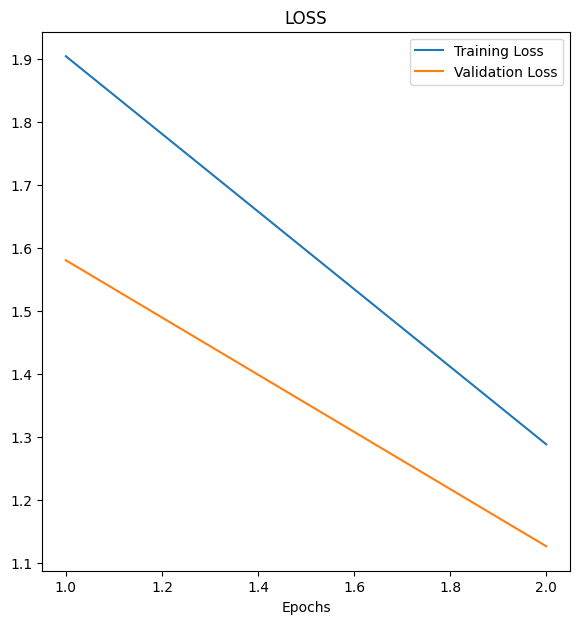

In [44]:
plot_curves(results)